## **Balancing a Pole on a Cart**
### 24S2 SC3000/CZ3005 Assignment 1
---
### Team Members
- Toh Jun Sheng
- Isaac Wong Jia Kai
- Tio Sher-min
---
### Contribution

#### Training the RL Agent

#### Task 1: Development of an RL Agent


#### Task 2: Demonstrate the effectiveness of the RL agent

#### Task 3: Render one episode played by the developed RL agent

#### Task 4: Format the Jupyter notebook
---

## Installing dependencies:

In [1]:
!pip install gym pyvirtualdisplay 
!pip install pygame gymnasium[classic-control] pyvirtualdisplay
!pip install --upgrade setuptools 
!pip install moviepy


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([-0.01543455,  0.01372217, -0.01990922, -0.00512431], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.0151601  -0.18110868 -0.0200117   0.28121114]
Reward for this step: 1.0
Is this round done? False


c:\Users\Jun Sheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation, _ = env.reset()
cumulative_reward = 0
done = False

while not done:
    observation, reward, terminated, truncated, info = env.step(0)
    done = terminated or truncated
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Training the Q agent

In [9]:
# Initialize environment
env = gym.make("CartPole-v1")

# Discretize the continuous observation space into bins
state_bins = [
    np.linspace(-4.8, 4.8, 15),     # Cart Position
    np.linspace(-5, 5, 15),         # Cart Velocity
    np.linspace(-0.418, 0.418, 15), # Pole Angle
    np.linspace(-5, 5, 15)          # Pole Angular Velocity
]

In [10]:
# Function to discretize a continuous state
def get_discrete_state(state):
    discrete_state = []
    for s, bins in zip(state, state_bins):
        index = np.digitize(s, bins)
        index = min(max(index, 0), len(bins))  # Clip to valid range
        discrete_state.append(index)
    return tuple(discrete_state)


# Epsilon-greedy action selection
def epsilon_greedy_action(state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(q_table[state])  # Exploit

# Q-table initialization
q_table = np.random.uniform(low=-1, high=1, size=([len(b) + 1 for b in state_bins] + [env.action_space.n]))

def q_policy_agent(observation):
    discrete_state = get_discrete_state(observation)
    return np.argmax(q_table[discrete_state])

In [11]:
# Hyperparameters
alpha = 0.1            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 1.0          # Initial exploration rate
epsilon_min = 0.05
epsilon_decay = 0.990
episodes = 10000       # Training episodes

Episode 0, Reward: 12.0, Epsilon: 0.990
Episode 500, Reward: 132.0, Epsilon: 0.050
Episode 1000, Reward: 30.0, Epsilon: 0.050
Episode 1500, Reward: 35.0, Epsilon: 0.050
Episode 2000, Reward: 175.0, Epsilon: 0.050
Episode 2500, Reward: 180.0, Epsilon: 0.050
Episode 3000, Reward: 102.0, Epsilon: 0.050
Episode 3500, Reward: 146.0, Epsilon: 0.050
Episode 4000, Reward: 192.0, Epsilon: 0.050
Episode 4500, Reward: 178.0, Epsilon: 0.050
Episode 5000, Reward: 93.0, Epsilon: 0.050
Episode 5500, Reward: 173.0, Epsilon: 0.050
Episode 6000, Reward: 160.0, Epsilon: 0.050
Episode 6500, Reward: 167.0, Epsilon: 0.050
Episode 7000, Reward: 144.0, Epsilon: 0.050
Episode 7500, Reward: 170.0, Epsilon: 0.050
Episode 8000, Reward: 181.0, Epsilon: 0.050
Episode 8500, Reward: 130.0, Epsilon: 0.050
Episode 9000, Reward: 191.0, Epsilon: 0.050
Episode 9500, Reward: 194.0, Epsilon: 0.050


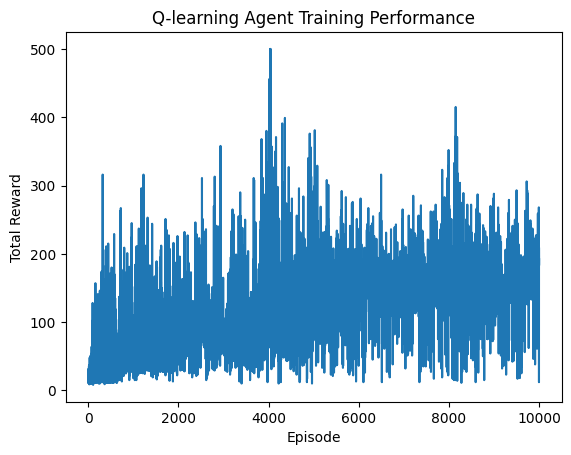

In [12]:
# Training
rewards = []

for episode in range(episodes):
    state = get_discrete_state(env.reset()[0])
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_action(state, epsilon)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = get_discrete_state(next_obs)

        # Q-learning update rule
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action]
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state
        total_reward += reward

    rewards.append(total_reward)

    # Epsilon decay
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Print progress
    if episode % 500 == 0:
        print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

# Plotting cumulative reward
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Agent Training Performance")
plt.show()

In [13]:
# === Task 1 Code ===
observation = env.reset()[0]  # Use [0] to get observation only (Gym v0.26+)
action = q_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.01971515 -0.02197058  0.02583115  0.03163083]
Chosen action: 1


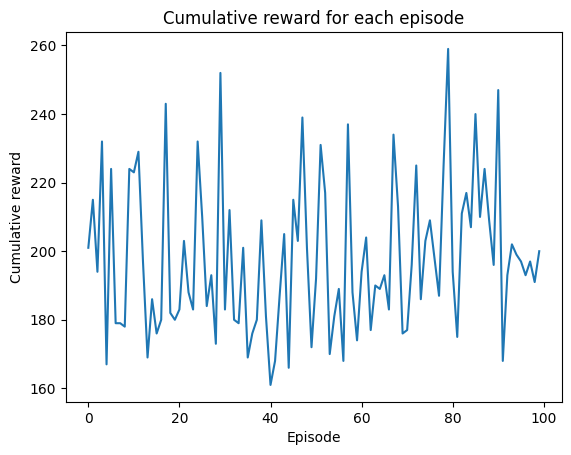

Average cumulative reward: 197.81
Is my agent good enough? True
Best episode index: 79
Best reward: 259.0


In [14]:
# === Task 2: Evaluation of Trained Agent ===

epsilon = 0.0
episode_results = []
best_episode_index = -1
best_reward = 0

# Use unwrapped environment for evaluation (faster)
env = gym.make("CartPole-v1", render_mode="rgb_array")

for episode in range(100):
    obs = env.reset(seed=episode)[0]  # fixed seed = reproducible episode
    state = get_discrete_state(obs)
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = get_discrete_state(next_obs)
        total_reward += reward

    episode_results.append(total_reward)

    if total_reward > best_reward:
        best_reward = total_reward
        best_episode_index = episode

env.close()

# === Plot rewards ===
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

# === Print result ===
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)
print("Best episode index:", best_episode_index)
print("Best reward:", best_reward)


In [15]:
# === Task 3: Record and Replay the Best Episode ===

# Create a new environment that records the best episode
env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="video",
    episode_trigger=lambda e: True
)

# Reset with the same seed used in Task 2
observation = env.reset(seed=best_episode_index)[0]
done = False

while not done:
    action = q_policy_agent(observation)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# === Display recorded video ===
show_video()


c:\Users\Jun Sheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video c:\Users\Jun Sheng\OneDrive\Desktop\SC3000-AI\video\rl-video-episode-0.mp4.
MoviePy - Writing video c:\Users\Jun Sheng\OneDrive\Desktop\SC3000-AI\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\Jun Sheng\OneDrive\Desktop\SC3000-AI\video\rl-video-episode-0.mp4
